<a href="https://colab.research.google.com/github/paddy3696/CNN_Pytorch/blob/main/guided_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot

import matplotlib.pyplot as plt
from matplotlib import gridspec
import random
import imageio
import os
import cv2
import glob

import tensorflow
from tensorflow import keras
from keras.utils import np_utils
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
from keras.callbacks import  Callback, EarlyStopping
from keras import regularizers
from keras.models import Sequential

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=43f48b7ed13be651b2bf13cb467e28c6382c1d63482def86c0295356848a3e85
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
wget.download('https://storage.googleapis.com/wandb_datasets/nature_12K.zip')
!unzip /content/nature_12K.zip

In [4]:
 # Load training and testing dataset
random.seed(9)
def test_data_gen(data_aug, batch_size):
  if data_aug:
      datagen = ImageDataGenerator(rotation_range=30,height_shift_range=0.2,
                horizontal_flip=True, 
                fill_mode='reflect',
                rescale=1./255
                )
  else:
      datagen = ImageDataGenerator(rescale=1./255)

  train_data = datagen.flow_from_directory(directory='inaturalist_12K/train',
              target_size = (224,224),
              batch_size=batch_size,
              class_mode="categorical",
              shuffle=True,
              seed=999)


  test_data = datagen.flow_from_directory(directory='inaturalist_12K/val',
            target_size=(224,224),
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=99)
  return test_data, train_data

In [5]:
def test():
    
    filter_org = [128,64,32,16,8]
    filter_size = (3,3)
    weight_decay = 1e-5
    dropout = 0.2
    activation_fn = 'selu'
    batch_size = 64
    data_aug = 'true'
    fc_n = 196
    
    input_shape = (224, 224, 3)
    
    model = Sequential()
    
    filter = filter_org
      
    model.add(Conv2D(filters = filter[0], kernel_size = filter_size,padding = 'same', input_shape = input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))


    model.add(Conv2D(filters = filter[1], kernel_size = filter_size,padding = 'same', input_shape = input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))


    model.add(Conv2D(filters = filter[2], kernel_size = filter_size,padding = 'same', input_shape = input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Conv2D(filters = filter[3], kernel_size = filter_size,padding = 'same', input_shape = input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    
    model.add(Conv2D(filters = filter[4], kernel_size = filter_size,padding = 'same', input_shape = input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    model.add(Flatten())
    model.add(Dense(fc_n, activation = activation_fn, kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dropout(dropout))

    model.add(Dense(10, activation = "softmax"))
 
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])

    train_data, test_data = test_data_gen(data_aug, batch_size)

    model.fit(train_data, epochs=10)
    
    model.evaluate(test_data, batch_size = batch_size)

    model.save("model_inat.h5")

    return model

In [6]:
model = test()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
32/32 [==============================] - 51s 1s/step - loss: 2.3625 - accuracy: 0.1242
Epoch 2/10
32/32 [==============================] - 37s 1s/step - loss: 2.2149 - accuracy: 0.1890
Epoch 3/10
32/32 [==============================] - 37s 1s/step - loss: 2.1498 - accuracy: 0.2194
Epoch 4/10
32/32 [==============================] - 37s 1s/step - loss: 2.1233 - accuracy: 0.2307
Epoch 5/10
32/32 [==============================] - 36s 1s/step - loss: 2.0975 - accuracy: 0.2596
Epoch 6/10
32/32 [==============================] - 37s 1s/step - loss: 2.0378 - accuracy: 0.2769
Epoch 7/10
32/32 [==============================] - 36s 1s/step - loss: 2.0292 - accuracy: 0.2792
Epoch 8/10
32/32 [==============================] - 37s 1s/step - loss: 1.9997 - accuracy: 0.2966
Epoch 9/10
32/32 [==============================] - 37s 1s/step - loss: 2.0154 - accuracy: 0.2847
Epoch 10/10
157/157 [===========

In [7]:
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 3, 128)
conv2d_1 (3, 3, 128, 64)
conv2d_2 (3, 3, 64, 32)
conv2d_3 (3, 3, 32, 16)
conv2d_4 (3, 3, 16, 8)


In [9]:
class_names = {0:'Amphibia', 1:'Animalia', 2:'Arachnida',3: 'Aves',4: 'Fungi',
              5: 'Insecta', 6:'Mammalia', 7:'Mollusca', 8:'Plantae',9: 'Reptilia'}

img_size = 224
dir = 'inaturalist_12K//val'

test_images = []
class_labels = []

for label, name in class_names.items():
  list_images = os.listdir(dir+'/'+name)
  res = []
  for ii in range(3):
    dummy = random.randint(0, 199)
    res.append(list_images[dummy])
  for image_name in res:
      image = imageio.imread(dir+'/'+name+'/'+image_name)
      if np.ndim(image) == 3:
        test_images.append(cv2.resize(image, (img_size,img_size)))
        class_labels.append(class_names[label])

test_images = np.array(test_images)
test_images = test_images/255.0

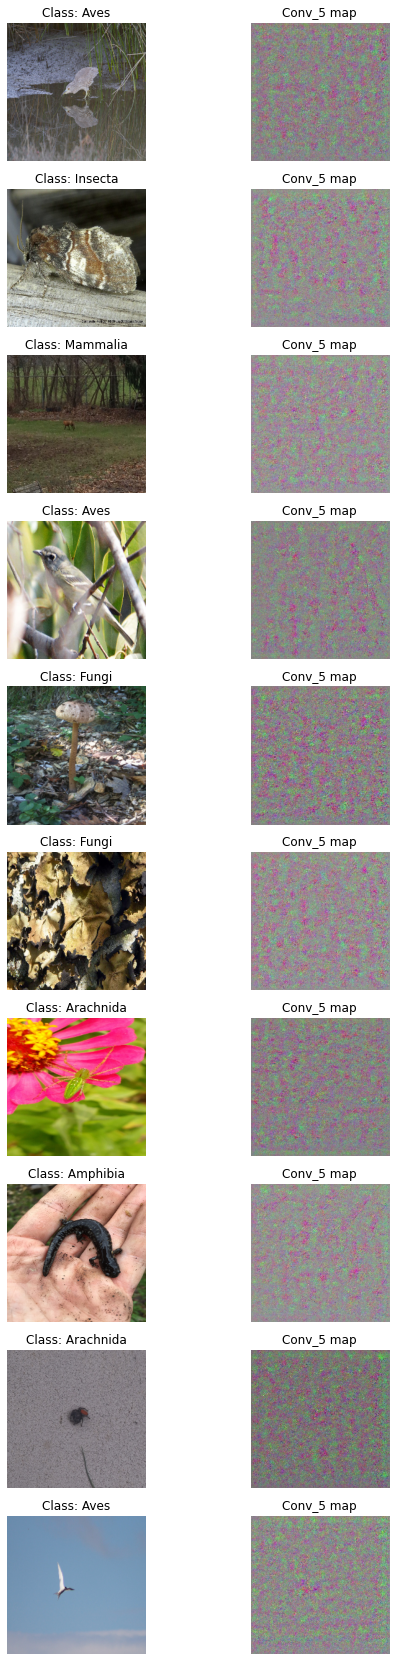

In [18]:
import tensorflow as tf

f, axarr = plt.subplots(10,2, figsize=(8, 30))
#random.randint(3, 9)
for ii in range(10):
  #idx = ii
  idx = random.randint(0, 20)

  image = test_images[idx]
  img_tensor = np.expand_dims(image, axis=0)

  covn5_model = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_4").output])

  @tf.custom_gradient
  def guidedRelU(x):
    def grad(dy):
      return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

  for layer in model.layers[1:]:
      if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.selu:
          layer.activation = guidedRelU

  with tf.GradientTape() as g:
    inputs = tf.cast(img_tensor, tf.float32)
    g.watch(inputs)
    outputs = covn5_model(inputs)[0]

  new_grad = g.gradient(outputs,inputs)[0]

  grad_img = np.dstack((new_grad[:, :, 0], new_grad[:, :, 1],new_grad[:, :, 2],))       
  grad_img = grad_img - np.min(grad_img)
  grad_img = grad_img/grad_img.max()
  
  axarr[ii,0].imshow(img_tensor[0])
  axarr[ii,0].set_title("Class: " + class_labels[idx])
  axarr[ii,0].axis("off")
  axarr[ii,1].imshow(grad_img)
  axarr[ii,1].axis("off")
  axarr[ii,1].set_title("Conv_5 map")

plt.show()